# Google drive mount
 * google colab 사용 시, google drive 내 데이터를 사용하기 위한 절차입니다

In [ ]:
# google drive에 있는 데이터를 사용하기 위해 접근

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# library import
 - 필요 library들을 import 하는 절차입니다
 - tensorflow, keras 등 필요 library들을 불러옵니다

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import applications
import matplotlib.pyplot as plt
import numpy as np

 - 현재 스크립트에서 GPU를 사용할 수 있는지 여부를 묻는 코드입니다

In [ ]:
# tensorflow를 import 하고, 현재 colab에서 gpu 구동이 되고 있는지 테스트 하는 코드
# Found GPU at: /device:GPU ~ 가 뜨면 성공

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data augmentation
 * 학습하기에 이미지 수가 적으므로 generator를 통해 변형된 추가 이미지들을 생성하는 과정입니다
 * 기존 이미지들을 뒤집거나 이동시켜 새로운 이미지들로 만들어냅니다

In [ ]:
"""
rotation_range: 이미지 회전 범위 (degrees)
width_shift, height_shift: 그림을 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위 (원본 가로, 세로 길이에 대한 비율 값)
rescale: 원본 영상은 0-255의 RGB 계수로 구성되는데, 이 같은 입력값은 모델을 효과적으로 학습시키기에 너무 높습니다 (통상적인 learning rate를 사용할 경우). 그래서 이를 1/255로 스케일링하여 0-1 범위로 변환시켜줍니다. 이는 다른 전처리 과정에 앞서 가장 먼저 적용됩니다.
shear_range: 임의 전단 변환 (shearing transformation) 범위
zoom_range: 임의 확대/축소 범위
horizontal_flip: True로 설정할 경우, 50% 확률로 이미지를 수평으로 뒤집습니다. 원본 이미지에 수평 비대칭성이 없을 때 효과적입니다. 즉, 뒤집어도 자연스러울 때 사용하면 좋습니다.
"""
datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

 - 위에서 정의한 ImageDataGenerator가 실제 이미지를 어떻게 변형시키는지 확인하는 과정입니다.

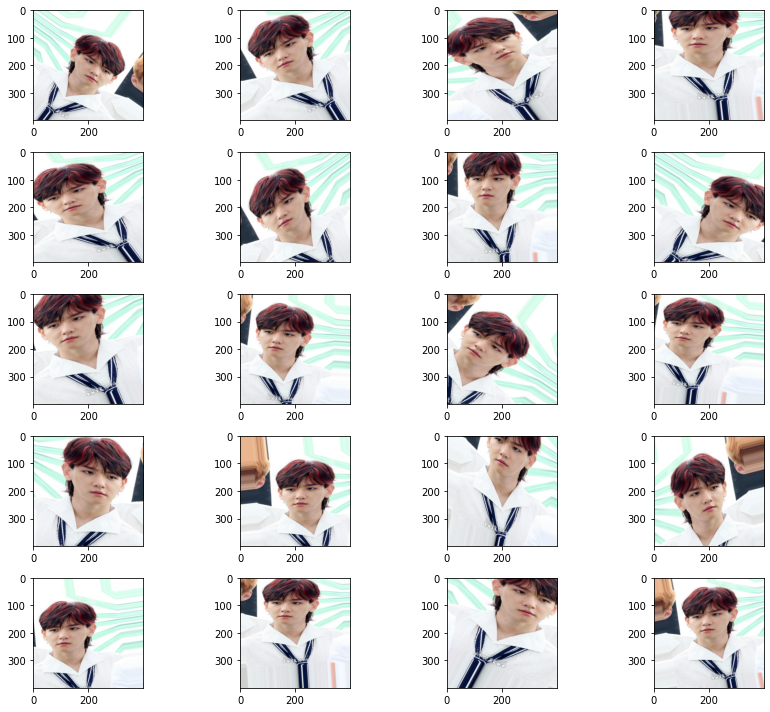

In [ ]:
img = image.load_img('/content/drive/MyDrive/숨고/조준용님(cnn 모델 비교)/data/EXO 백현/EXO 백현4.jpg', target_size=(400, 400))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
idx = 0
fig = plt.figure(figsize=(12, 10))
axs = []
for batch in datagen.flow(x , batch_size=1): # 여기서 batch는 x가 됨
    axs.append(fig.add_subplot(5, 4, idx+1))
    axs[idx].imshow(image.array_to_img(batch[0]))
    idx += 1
    if idx%20 == 0:
        break
fig.tight_layout()
plt.show()

# hyper parameter 세팅
 - 딥러닝 학습과 관련된 초기 세팅값입니다. 배치 사이즈, 에폭 등 학습 설정값을 정합니다

In [ ]:
## 딥러닝 학습 관련
batch_size = 32 # train batchsize(학습 셋이 적으므로 배치 수도 8로 설정)
epochs = 300 # epochs
learning_rate = 0.00001 # learning rate(현재 상황에서 학습률이 높으면 gradient가 발산하는것 확인)

# Model Load, fine-tuning
 - 각 폴더 내 이미지들을 train(학습) / validation(검증) 으로 나눕니다. 이미지를 불러올 때, 위에서 설정한 imagegenerator를 사용하여 변형된 데이터를 증강하며, 학습에 사용할 배치 사이즈는 위에서 정한 32, 이미지 사이즈는 200 x 200으로 맞추고, 분류 문제이므로 class_mode는 categorical로 설정합니다

In [ ]:
# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = datagen.flow_from_directory("/content/drive/MyDrive/숨고/조준용님(cnn 모델 비교)/data",
                                              batch_size = batch_size,
                                              target_size = (200, 200), # 모든 이미지의 크기가 200 x 200 조정됩니다.
                                              class_mode='categorical',
                                              subset='training')

validation_generator = datagen.flow_from_directory("/content/drive/MyDrive/숨고/조준용님(cnn 모델 비교)/data",
                                                   batch_size=batch_size,
                                                   target_size=(200, 200),
                                                   class_mode='categorical',
                                                   subset='validation') # set as validation data

Found 5934 images belonging to 126 classes.
Found 1417 images belonging to 126 classes.


 - keras에서 제공하는 vgg / resnet/ xception model을 불러옵니다.
 - 모델은 imagenet에서 사용된 모델을 가져오며, include_top=False를 통해 fully-connected layer 부분을 제외한 나머지 layer를 가져오게 합니다. 이미지 사이즈는 200 x 200이므로 input shape또한 200, 200, 3으로 설정합니다
 - 우선 새롭게 fully-connected 부분만 만들 목적이므로, 가져온 layer들은 학습되지 않도록 합니다(layer.trainable = False)
 - fully-connected layer를 다 쌓고 나면 optimizer는 adam으로 설정하고, early stoping을 통해 20 epoch 이상 성능의 변화가 없으면 학습을 종료핟로고 합니다
 - fit_generator를 통해 위에서 설정한 train_generator, validation_generator를 사용하여 학습 및 검증을 진행합니다.

In [ ]:
# vgg16 모델을 불러옵니다(pretrained)
# weigths 는 imagenet에서 학습한 것을 가져오며, include_top = False이면 fully connected 층을 제외합니다.
vgg_model = applications.VGG16(weights='imagenet', include_top=False,  input_shape=(200, 200, 3)) #

for layer in vgg_model.layers: # layer는 tuning하지 않도록 freezing 시킴
    layer.trainable = False

vgg_model_final = vgg_model.output
vgg_model_final = AveragePooling2D(pool_size=(6, 6))(vgg_model_final)
vgg_model_final = Flatten(name="flatten")(vgg_model_final)
vgg_model_final = Dense(32, activation="relu")(vgg_model_final)
vgg_model_final = Dropout(0.5)(vgg_model_final)
vgg_model_final = Dense(126, activation="softmax")(vgg_model_final)
vgg_model_final = Model(inputs=vgg_model.input, outputs=vgg_model_final)
optimizer = optimizers.Adam(learning_rate=learning_rate) # optimizer 지정
vgg_model_final.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])

# early stopping 및 모델 저장관련 설정입니다
checkpoint = ModelCheckpoint("vgg16_finetuned.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc',patience=20, verbose=1, mode='max')

# Fine tuning 학습을 수행합니다.
vgg_model_final.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint,early])

In [ ]:
resnet_model = applications.ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(200, 200, 3)))

for layer in resnet_model.layers:
	layer.trainable = False

resnet_model_final = resnet_model.output
resnet_model_final = AveragePooling2D(pool_size=(7, 7))(resnet_model_final)
resnet_model_final = Flatten(name="flatten")(resnet_model_final)
resnet_model_final = Dense(32, activation="relu")(resnet_model_final)
resnet_model_final = Dropout(0.5)(resnet_model_final)
resnet_model_final = Dense(126, activation="softmax")(resnet_model_final)
resnet_model_final = Model(inputs=resnet_model.input, outputs=resnet_model_final)
optimizer = optimizers.Adam(learning_rate=learning_rate) # optimizer 지정
resnet_model_final.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# early stopping 및 모델 저장관련 설정입니다
checkpoint = ModelCheckpoint("resnet_finetuned.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc',patience=20, verbose=1, mode='max')

# Fine tuning 학습을 수행합니다.
resnet_model_final.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint,early])

In [ ]:
xception_model = applications.Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(200, 200, 3)))

for layer in xception_model.layers:
	layer.trainable = False

xception_model_final = xception_model.output
xception_model_final = AveragePooling2D(pool_size=(7, 7))(xception_model_final)
xception_model_final = Flatten(name="flatten")(xception_model_final)
xception_model_final = Dense(32, activation="relu")(xception_model_final)
xception_model_final = Dropout(0.5)(xception_model_final)
xception_model_final = Dense(126, activation="softmax")(xception_model_final)
xception_model_final = Model(inputs=xception_model.input, outputs=xception_model_final)
optimizer = optimizers.Adam(learning_rate=learning_rate) # optimizer 지정
xception_model_final.compile(loss="categorical_crossentropy", optimizer=optimizer,
	metrics=["accuracy"])

# early stopping 및 모델 저장관련 설정입니다
checkpoint = ModelCheckpoint("xception_finetuned.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc',patience=20, verbose=1, mode='max')

# Fine tuning 학습을 수행합니다.
xception_model_final.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint,early])

# Model evaluation

 - 위에서 학습한 3개의 모델을 평가하는 코드입니다.

In [ ]:
print("--VGG16 Evaluate --")
vgg_scores = vgg_model_final.evaluate_generator(validation_generator)
print("%s: %.2f%%" %(vgg_model_final.metrics_names[1], vgg_scores[1]*100))

In [ ]:
print("--resnet Evaluate --")
resnet_scores = resnet_model_final.evaluate_generator(validation_generator)
print("%s: %.2f%%" %(resnet_model_final.metrics_names[1], resnet_scores[1]*100))

In [ ]:
print("--xception Evaluate --")
xception_scores = xception_model_final.evaluate_generator(validation_generator)
print("%s: %.2f%%" %(xception_model_final.metrics_names[1], xception_scores[1]*100))